In [ ]:
import tensorflow as tf
import tensorflow.contrib.keras as keras
import numpy as np

import os
import pickle
import pandas
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense, Embedding
from keras.layers import LSTM

import re
from collections import Counter

In [2]:
text = u'This dog \U0001f602'
print(text) # with emoji

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
print(emoji_pattern.sub(r'', text)) # no emoji

This dog 😂
This dog 


In [3]:
result_to_int = dict([("negative", 0),("neutral", 1),("positive", 2)])

In [82]:
tweets = pandas.read_csv("./Tweets.csv")
tweetsX = tweets['text']
tweetsY = tweets['airline_sentiment']

tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [83]:
tweetsX=np.array(tweetsX)

flattenWords = []

for x in range(0,len(tweetsX)):
    before = tweetsX[x];
    tweetsX[x] = emoji_pattern.sub(r'', tweetsX[x])
    #if (len(before)!=len(tweetsX[x])):
        #print(before)
        #print (tweetsX[x])
    tweetsX[x] = tweetsX[x].lower().split()
    #print (st)
    flattenWords.extend(tweetsX[x])

freqCount = dict(Counter(flattenWords))
print (len(freqCount))
shrinkDict = {k:v for k,v in freqCount.items() if v >1}
shrinkDict["UNK"] = len(freqCount) - len(shrinkDict);
print (len(shrinkDict))
#uniqueWords = [x.upper() for x in uniqueWords]

uniqueWords = sorted(list(set(shrinkDict.keys())))
#print (uniqueWords)   
word_to_int = dict((c, i) for i, c in enumerate(uniqueWords))
int_to_word = dict((i, c) for i, c in enumerate(uniqueWords))



26607
9204


In [84]:
#print (word_to_int.keys())
for x in range(0,len(tweetsX)):
    #print(tweetsX[x])
    result = [s if s in word_to_int.keys() else "UNK" for s in tweetsX[x]]
    #print (result)
    tweetsX[x] =[word_to_int[w] for w in result]
    
print (tweetsX)



[[1328, 8897, 1336, 7271]
 [1328, 6532, 9144, 1440, 2734, 8276, 8121, 1336, 1336]
 [1328, 4758, 3286, 8291, 5811, 5568, 4758, 5852, 8276, 8021, 1683, 8405]
 ..., [1132, 6512, 2251, 1648, 1552, 8276, 1336]
 [1132, 9134, 4471, 5815, 5748, 9134, 2497, 5815, 3981, 1660, 3408, 1684, 9155, 1336, 1702, 6184, 7923, 7650, 4758, 2381, 5486, 5815, 1336]
 [1132, 8829, 4471, 1058, 6596, 7650, 8829, 5852, 731, 5158, 4690, 5506, 7366, 1776, 6079, 8121, 5883, 3984, 6535, 6765, 8636, 6079, 7784, 4093, 886, 6364, 6079, 8121, 5883, 3990]]


In [85]:
#making a train / test split
tweetsCount = len(tweets)
test_split = int(tweetsCount*0.9)

x_train, y_train = tweetsX[0:test_split], tweetsY[0:test_split]
x_test, y_test = tweetsX[test_split:], tweetsY[test_split:] 

In [86]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [87]:

for x in range(0,len(y_train)):
    y_train[x] =result_to_int[y_train[x]]


In [88]:

for x in range(0,len(y_test)):
    y_test[x] =result_to_int[y_test[x]]

In [89]:
y_train = keras.utils.to_categorical(y_train, 3)
y_test = keras.utils.to_categorical(y_test, 3)

In [90]:
maxLen = 25
batch_size = 32
max_features = 20000
x_train = sequence.pad_sequences(x_train, maxlen=maxLen)
x_test = sequence.pad_sequences(x_test, maxlen=maxLen)

In [95]:
x_test[11]

array([   0,    0,    0,    0,    0,    0, 1132, 1336, 1613, 4471, 8455,
       1336, 8276, 8126, 2320, 1744, 5403, 1336, 1997, 6079, 8123, 4617,
       3399, 7054, 1417], dtype=int32)

In [99]:
for x in range(0,len(x_test[11])):
    st =[int_to_word[w] for w in x_test[11]]
print (st)

print (y_test[11])

['!', '!', '!', '!', '!', '!', '@americanair', 'UNK', 'already', 'have', 'turned', 'UNK', 'to', 'them,', 'but', 'apparently', 'losing', 'UNK', 'bag', 'on', 'their', 'honeymoon', "doesn't", 'require', 'accountability']
[ 1.  0.  0.]


In [100]:
maxLen = 25
batch_size = 32
max_features = len(word_to_int)

In [101]:
model = Sequential()
model.add(Embedding(max_features, 64, input_length=25))
model.add(LSTM(64, recurrent_dropout=0.2, return_sequences=True)) 
model.add(LSTM(64, dropout=0.2))
model.add(Dense(3, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [104]:
history = model.fit(x_train, y_train,batch_size=batch_size,epochs=10,validation_data=(x_test, y_test))

Train on 13176 samples, validate on 1464 samples
Epoch 1/10
13176/13176 [==============================] - 86s - loss: 0.0680 - acc: 0.9758 - val_loss: 0.4682 - val_acc: 0.8739

In [111]:
%matplotlib inline
import matplotlib.pyplot as plt
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

{'val_loss': [0.46818331714536321, 0.50118644739109308, 0.46899633361993592, 0.51925298653013718, 0.55036133951176713, 0.54116702210056322, 0.61427721462614548, 0.65198151433402718, 0.63097795958076019, 0.67805261820391882], 'val_acc': [0.87386157701575695, 0.86976320984585043, 0.88160292437819188, 0.87909836684419806, 0.87682150459028985, 0.8790983759640344, 0.8731785146265082, 0.8750000078170026, 0.86589254023598838, 0.86725865915173395], 'loss': [0.067969851380154156, 0.060837339721258182, 0.052349230487738763, 0.04836055603382728, 0.04091133719322039, 0.040833849056426529, 0.034316740144365344, 0.031730614882365435, 0.033053521453258745, 0.026591319416042612], 'acc': [0.97581461953190363, 0.9785974571107009, 0.98057074016994905, 0.98310059142532535, 0.98535216064545772, 0.98535215963214251, 0.98661708585696284, 0.98843857890269793, 0.98737604066539553, 0.98998178680086402]}


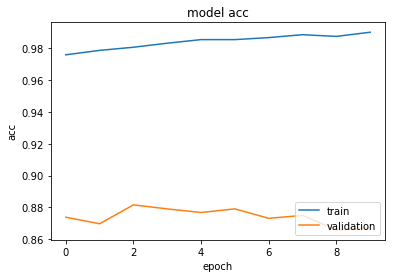

In [112]:
plot_train(history)
print (history.history)

In [56]:
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

1440/1464 [============================>.] - ETA: 0s

In [57]:
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.553357625268
Test accuracy: 0.882058294419
